In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import re

from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, f1_score

In [2]:
# Data loading
def load_dataset(path: str, feature_num: int) -> pd.DataFrame:
    """
    Args:
        path: path of data file
        feature_num: the number of freature
    Retruns:
        data(dataFrame)
    """
    col = ["Class Label"]
    col.extend([f"Feature {i}" for i in range(1, feature_num+1)])

    return pd.read_excel(path, header=0, usecols=col)

In [3]:
# Data eavaluation
def performance_eval(Y, pred, type="accuracy"):
    """
    Args:
        Y(np.ndarray): array of true label
        pred(np.ndarray): array of predictions
        type(str): accuracy / precision / recall / F1 score
    Returns:
        score of performance evaluation
    """
    if type == "accuracy":
        return accuracy_score(Y, pred, average="macro")
    elif type == "precision":
        return precision_score(Y, pred, average="macro")
    elif type == "recall":
        return recall_score(Y, pred, average="macro")
    elif type == "F1 score":
        return f1_score(Y, pred, average="macro")
    else:
        raise ValueError("Wrong type")

In [4]:
# Data exploration
def check_data(df: pd.DataFrame, feature_num: int, graph_type: str="hist") -> plt:
    """
    Arags:
        df: dataFrame
        feature_num: Number of feature (e.g. 1, 2, 3, ...)
            if you input feature_num -1,
                you can check all data
        graph_type: hist (histogram) / box (boxplot)
    Returns:
        plot
    """
    columns = [int(re.findall("[0-9]+", c)[0]) for c in df.columns if "Class" not in c]
    columns.append(-1)
    if feature_num in columns:
        plt.figure(figsize=(8, 6))
        if graph_type == "hist":
            if feature_num != -1:
                # Histogram
                plt.hist(df[f"Feature {feature_num}"])
                plt.ylabel("Frequency")
                plt.xlabel(f"Range of feature {feature_num}")
                plt.title(f"Histogram of feature {feature_num}")
            else:
                raise ValueError("Do not supoort check all data for histogram")
        if graph_type == "box":
            if feature_num == -1:
                # All of boxplot
                plt.boxplot(df)
                plt.ylabel("Range of feature")
                plt.xlabel(f"Type of feature")
                plt.title(f"Boxplot of feature")
            else:
                # Boxplot
                plt.boxplot(df[f"Feature {feature_num}"])
                plt.ylabel("Range of feature")
                plt.xlabel(f"Type of feature")
                plt.title(f"Boxplot of feature {feature_num}")

        return plt.show()
    else:
        raise ValueError("Feature number is not in data")

In [5]:
# data prerpocessing

In [6]:
# Data split
def train_test_split(data: np.ndarray, test_ratio: float) -> np.ndarray:
    """
    Args:
        data(np.ndarray): data (class column sholud be 0)
        test_ratio(float): ratio of test data
    Returns:
        X_train(np.ndarray), X_test(np.ndarray), Y_train(np.ndarray), Y_test(np.ndarray)
    """
    np.random.shuffle(data)
    test, train = np.vsplit(data, [int(len(data)*test_ratio)])
    y_train, x_train = np.hsplit(train, [1])
    y_test, x_test = np.hsplit(test, [1])

    return x_train, x_test, np.concatenate(y_train), np.concatenate(y_test)

In [7]:
# Definition of RDA model
class RDA:
    """
    Regularized Discrminant Analysis Model
    """
    def __init__(self, alpha: float=0.0, beta: float=0.0):
        """
        Args:
            alpha(float): Regularization parameter (0 <= alpha <= 1)
            beta(float): Additional regularization parameter (0 <= beta <= 1)
        """
        self.alpha = alpha
        self.beta = beta
        self.class_list = []
        self.class_prior = {}
        self.class_means = {}
        self.reg_cov = {}
        self.rda_cov = {}
        self.learn = False

    def reset(self):
        self.class_list = []
        self.class_prior = {}
        self.class_means = {}
        self.reg_cov = {}
        self.rda_cov = {}

    def fit(self, x: np.ndarray, y: np.ndarray) -> None:
        """
        Args:
            X(np.ndarray): Train data(shape[n_samples, n_feautres])
            Y(np.ndarray): Class label(shape[n_samples, 1])
        Returns:
            None. Only parameters of class is changed
        """
        self.class_list = np.unique(y)
        class_cov = {}
        pooled_cov = 0
        for c in self.class_list:
            x_index = np.where(y == c)[0]
            x_data = x[x_index, :]  # data of each class
            self.class_prior[c] =   float(len(x_index) / len(y))  # class prior probability
            self.class_means[c] = x_data.mean(axis=0)  # class mean vector
            class_cov[c] = np.cov(x_data, rowvar=0)  # covariance matrix
            # Calculate the pooled covariance estimate
            pooled_cov += class_cov[c] * self.class_prior[c]
        # Calculate regularized covariance matrics
        for c in self.class_list:
            self.reg_cov[c] =  ((1 - self.alpha) * class_cov[c]) + \
                                    (self.alpha * pooled_cov)
        # Calcualte RDA covariance matrics
        for c in self.class_list:
            self.rda_cov[c] = ((1 - self.beta) * self.reg_cov[c]) + \
                                self.beta * (1 / self.class_prior[c]) * \
                                    np.trace(self.reg_cov[c]) * np.eye(self.reg_cov[c].shape[0])
        self.learn = True
    
    def predict(self, x):
        """
        Args:
            X(np.ndarray)
        Returns:
            label of prediction(int)
        """
        # RDA have to fit before prediction
        if self.learn is not True:
            raise ValueError("RDA model does not trained")
        # Prediction
        class_prob = {}
        for c in self.class_list:
            diff_class = x - self.class_means[c]
            class_prob[c] = -0.5 * np.matmul(np.matmul(diff_class.T, np.linalg.pinv(self.rda_cov[c])), diff_class)
            class_prob[c] -= 0.5 * np.log(np.linalg.det(self.rda_cov[c]))
            class_prob[c] += np.log(self.class_prior[c])

        return max(class_prob, key=class_prob.get)

In [8]:
# Model selection
class ModelSelection:
    def __init__(self, model, params_set):
        self.model = model
        self.params = {}
        self.params_set = params_set

    def cross_validation(self, x, y, k):
        alpha_list = \
            np.arange(self.params_set["alpha"][0], self.params_set["alpha"][1], 0.1)
        beta_list = \
            np.arange(self.params_set["beta"][0], self.params_set["beta"][1], 0.1)
        
        # Split data
        x_split = np.array_split(x, k)
        y_split = np.array_split(y, k)

        best_score = 0
        for alpha in alpha_list:
            scores = []
            for beta in beta_list:
                # Check score
                for i in range(k):
                    # Deepcopy tarin data
                    x_copy = x_split.copy()
                    y_copy = y_split.copy()
                    # Get model
                    self.model.reset()
                    self.model.alpha = alpha
                    self.model.beta = beta
                    # Pop for test data
                    test_x = x_copy.pop(i)
                    test_y = y_copy.pop(i)
                    # Concatenate for train data
                    train_x = np.concatenate(x_copy)
                    train_y = np.concatenate(y_copy)
                    # Fit model
                    self.model.fit(train_x, train_y)
                    # Prediction
                    pred = []
                    for x in test_x:
                        pred.append(self.model.predict(x))
                    # Check scores
                    scores.append(performance_eval(test_y, pred, "F1 score"))
                mean_score = np.mean(scores)

                if mean_score >= best_score:
                    # if mean_score - best_score >= 0.01:
                    print(f"alpha : {alpha}, beta : {beta}, F1 score : {mean_score}")
                    best_score = mean_score
                    self.params["alpha"] = alpha
                    self.params["beta"] = beta
                    self.params["cov"] = self.model.rda_cov
                    self.params["class_list"] = self.model.class_list
                    self.params["class_means"] = self.model.class_means
                    self.params["class_prior"] = self.model.class_prior
                    self.params["learn"] = True

        return self.params

In [9]:
path = "facial_expression_train_dataset.xlsx"
df = load_dataset(path, 21)
data = np.array(df)
X_train, X_test, Y_train, Y_test = train_test_split(data, 0.2)
rda = RDA()
params_set = {"alpha": [0,1], "beta": [0,1]}
ms = ModelSelection(rda, params_set)
params = ms.cross_validation(X_train, Y_train, 4)


<ipython-input-7-fc6e7442d0c0>:73: RuntimeWarning: invalid value encountered in log
  class_prob[c] -= 0.5 * np.log(np.linalg.det(self.rda_cov[c]))


alpha : 0.0, beta : 0.0, F1 score : 0.16653491436100132
alpha : 0.0, beta : 0.1, F1 score : 0.3971143741524176
alpha : 0.1, beta : 0.0, F1 score : 0.8523328523328523
alpha : 0.2, beta : 0.0, F1 score : 0.9060759501935972
alpha : 0.30000000000000004, beta : 0.0, F1 score : 0.92866970991971
alpha : 0.4, beta : 0.0, F1 score : 0.9733610615963557
alpha : 0.5, beta : 0.0, F1 score : 0.9733610615963557
alpha : 0.6000000000000001, beta : 0.0, F1 score : 0.9875222816399287
alpha : 0.7000000000000001, beta : 0.0, F1 score : 0.9875222816399287
alpha : 0.8, beta : 0.0, F1 score : 0.9875222816399287


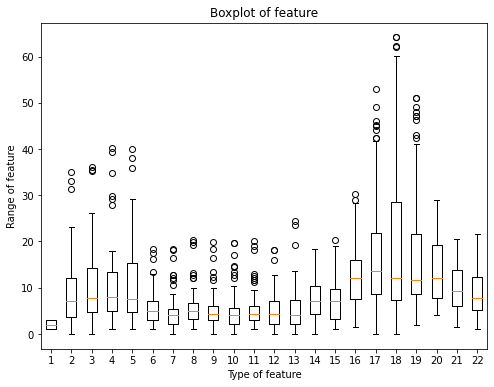

In [10]:
check_data(df, -1, "box")

In [11]:
rda = RDA()
rda.alpha = params["alpha"]
rda.beta = params["beta"]
rda.rda_cov = params["cov"]
rda.class_means = params["class_means"]
rda.class_prior = params["class_prior"]
rda.class_list = params["class_list"]
rda.learn = params["learn"]

pred = []
for x in X_test:
    pred.append(rda.predict(x))

score = performance_eval(Y_test, pred, "F1 score")

score.mean()

0.9474747474747475

In [12]:
params

{'alpha': 0.8,
 'beta': 0.0,
 'cov': {1.0: array([[ 1.88990121e+01,  1.68976064e+01,  1.72100777e+01,
           1.65783302e+01,  4.57769940e+00,  2.92964519e+00,
           3.68679779e+00,  4.75091379e+00,  2.22574704e+00,
           2.84176871e+00,  1.16485202e+00,  5.57039769e+00,
          -1.98105242e+00, -1.34823557e+00, -5.01474556e+00,
          -6.40761622e+00, -6.56658209e+00, -9.52917334e+00,
          -6.30815694e+00,  1.39509446e+00, -2.00737836e+00],
         [ 1.68976064e+01,  2.09379624e+01,  1.77295931e+01,
           1.58452010e+01,  5.73764220e+00,  4.64642860e+00,
           5.88022327e+00,  7.07767731e+00,  4.78202978e+00,
           4.44286112e+00,  2.49821108e+00,  7.11913900e+00,
          -5.65743772e-01, -4.54541208e-01, -3.77968879e+00,
          -5.32138205e+00, -5.00768300e+00, -9.17542770e+00,
          -5.92654222e+00,  2.78418507e+00, -1.28893393e-02],
         [ 1.72100777e+01,  1.77295931e+01,  2.16135687e+01,
           1.71174467e+01,  4.64780674e+00

In [13]:
# performance evaluation